## **Exploratory Data Analysis**

Before introducing any model, we conducted an exploratory data analysis to clean and better understand our dataset.
 
The dataset used in this project was obtained from Kaggle and is available at the following link:     
[Multilingual Customer Support Tickets](https://www.kaggle.com/datasets/tobiasbueck/multilingual-customer-support-tickets?select=dataset-tickets-multi-lang3-4k.csv)   
 
It contains a collection of real-world customer support tickets written in english or german, along with metadata such as ticket subject, body, language, assigned queue, priority, and various tags.    
 
We chose this dataset because it offers rich information (dataset size: 20k records) that allows us to classify the appropriate queue for each support ticket based on the given details. By analyzing the info given, we aim to predict which team or department (queue) should handle the ticket.     
 
This classification task can help to automatize the assignment process in customer support systems, ensuring that each ticket is directed to the right team for a timely and effective response.

### Import Libraries

In [45]:
import sys
sys.path.append('..')

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.data_exploration_utils import *


### Dataset

In [18]:
# Read the CSV file into a DataFrame
df_tickets_initial = pd.read_csv('../data/dataset-tickets-multi-lang-4-20k.csv')
df_tickets_initial.head()

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN


In [55]:
df_tickets_initial.shape

(20000, 15)

We can appreciate that the dataset contains the next variables:
- `subject`: Subject of the customer's email.
- `body`: Body of the customer's email.
- `answer`: The response provided by the helpdesk agent.
- `type`: The type of ticket as picked by the agent (Incident, Request, Problem, Change).
- `queue`: Specifies the department to which the email ticket is routed (General Inquiry, Customer Service, Technical Support, IT Support, Product Support, Billing and Payments, Service Outages and Maintenance, Human Resources, Returns and Exchanges, Sales and Pre-Sales). 
- `priority`: Indicates the urgency and importance of the issue (low, medium, high).
- `language`: Indicates the language in which the email is written (de, en).
- `tag`: Tags/categories assigned to the ticket to further classify and identify common issues or topics, split into ten columns in the dataset (examples: "Product Support," "Technical Support," "Sales Inquiry").

##### Selection of variables

To predict the appropriate support ticket queue, we kept only the most relevant information. We retained the subject and body of the customer message and the language field, which is essential for distinguishing the language during model training.    

We excluded the answer field because it is provided after the queue is assigned, as well as the type, priority, and tag_1 to tag_8 fields due to their inconsistency or unreliability at ticket submission.     

In summary, we use only the customer's message (subject and body) and language to ensure a simple, fair, and effective model.

In [19]:
df_tickets_filtered = df_tickets_initial[['subject', 'body', 'language', 'queue']].copy()
df_tickets_filtered.head()

,subject,body,language,queue
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,de,General Inquiry
1,Customer Support Inquiry,Seeking information on digital strategies that...,en,Customer Service
2,Data Analytics for Investment,I am contacting you to request information on ...,en,Customer Service
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,de,Customer Service
4,Security,"Dear Customer Support, I am reaching out to in...",en,Customer Service


##### Check for duplicates

In [20]:
duplicate_count = df_tickets_filtered.duplicated().sum()
print(f"Number of duplicate records: {duplicate_count}")

Number of duplicate records: 0


##### Check datatypes and missing values

In [21]:
df_tickets_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   18539 non-null  object
 1   body      19998 non-null  object
 2   language  20000 non-null  object
 3   queue     20000 non-null  object
dtypes: object(4)
memory usage: 625.1+ KB


We observed 18,539 missing values for subject and 19,998 for body.      

Since having data in either field is useful, we will concatenate subject and body into a single variable called text, and only remove records where both fields are missing.

In [ ]:
nan_in_both = df_tickets_filtered[ df_tickets_filtered['body'].isna() & df_tickets_filtered['subject'].isna() ].shape[0]
print(f"Number of records with NaN in both 'body' and 'subject': {nan_in_both}")

Number of records with NaN in both 'body' and 'subject': 0


In [22]:
df_tickets = df_tickets_filtered.copy()
df_tickets['text'] = df_tickets['subject'].fillna('') + " " + df_tickets['body'].fillna('')
df_tickets = df_tickets.drop(columns=['subject', 'body'])
df_tickets.head()

,language,queue,text
0,de,General Inquiry,Unvorhergesehener Absturz der Datenanalyse-Pla...
1,en,Customer Service,Customer Support Inquiry Seeking information o...
2,en,Customer Service,Data Analytics for Investment I am contacting ...
3,de,Customer Service,Krankenhaus-Dienstleistung-Problem Ein Medien-...
4,en,Customer Service,"Security Dear Customer Support, I am reaching ..."


In [23]:
df_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  20000 non-null  object
 1   queue     20000 non-null  object
 2   text      20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


All variables are of type object, which is appropriate since they all contain strings.     
Additionally, no missing values are present.

##### Analyze class imbalance

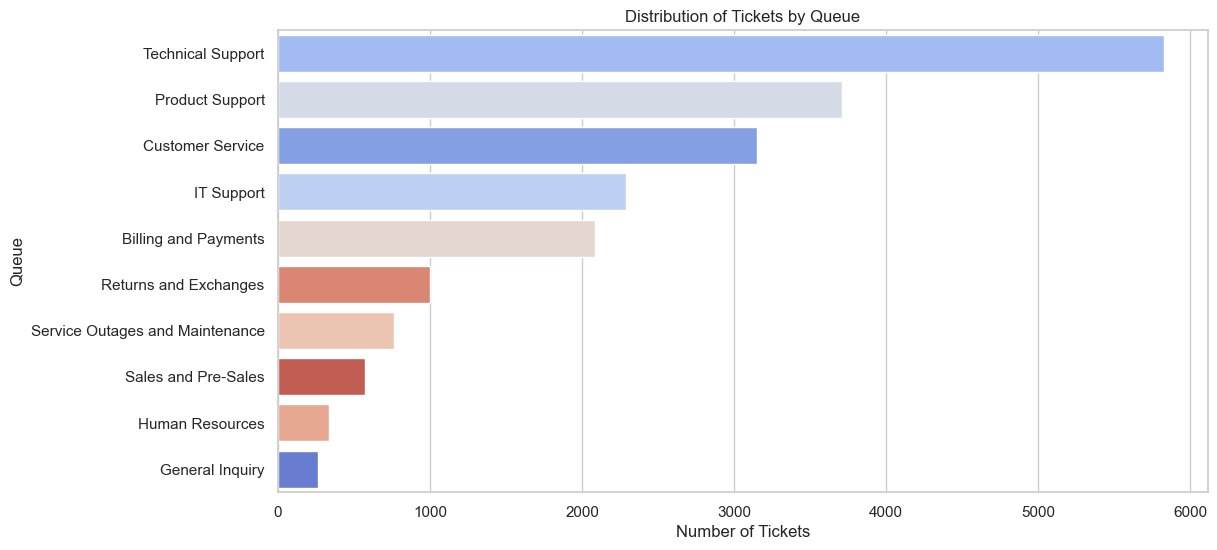

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.countplot(y=df_tickets['queue'], order=df_tickets['queue'].value_counts().index, palette="coolwarm", hue=df_tickets['queue'])
plt.title("Distribution of Tickets by Queue")
plt.xlabel("Number of Tickets")
plt.ylabel("Queue")
plt.show()

In [50]:
check_class_imbalance(df_tickets, 'queue')

,Counts,Percentage
queue,,
Technical Support,5824,29.12
Product Support,3708,18.54
Customer Service,3152,15.76
IT Support,2292,11.46
Billing and Payments,2086,10.43
Returns and Exchanges,1001,5.00
Service Outages and Maintenance,764,3.82
Sales and Pre-Sales,572,2.86
Human Resources,338,1.69


In [51]:
df_tickets['queue'].value_counts()

queue
Technical Support                  5824
Product Support                    3708
Customer Service                   3152
IT Support                         2292
Billing and Payments               2086
Returns and Exchanges              1001
Service Outages and Maintenance     764
Sales and Pre-Sales                 572
Human Resources                     338
General Inquiry                     263
Name: count, dtype: int64